In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Figure 5/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
train = sc.read("../data/train_species.h5ad")
train

AnnData object with n_obs × n_vars = 62114 × 6619 
    obs: 'condition', 'species', 'individual', 'batch', 'louvain', 'n_counts'
    var: 'gene_ids-0-0-0-0', 'gene_ids-1-0-0-0', 'gene_ids-2-0-0-0', 'gene_ids-0-1-0-0', 'gene_ids-1-1-0-0', 'gene_ids-2-1-0-0', 'gene_ids-0-0-1-0', 'gene_ids-1-0-1-0', 'gene_ids-2-0-1-0', 'gene_ids-0-1-1-0', 'gene_ids-1-1-1-0', 'gene_ids-2-1-1-0', 'gene_ids-3-1-1-0', 'gene_ids-0-0-0-1', 'gene_ids-1-0-0-1', 'gene_ids-2-0-0-1', 'gene_ids-0-1-0-1', 'gene_ids-1-1-0-1', 'gene_ids-2-1-0-1', 'gene_ids-0-0-1-1', 'gene_ids-1-0-1-1', 'gene_ids-2-0-1-1', 'gene_ids-0-1-1-1', 'gene_ids-1-1-1-1', 'gene_ids-2-1-1-1'
    uns: 'condition_colors', 'neighbors', 'species_colors'
    obsm: 'X_pca', 'X_umap'

In [4]:
network = scgen.VAEArith(x_dimension=train.shape[1], z_dimension=100, model_path="../models/scGen/species/rat/scgen")
network.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/species/rat/scgen


In [5]:
rabbit = train[train.obs["species"] == "rabbit"]
rabbit_cd = rabbit[rabbit.obs["condition"] == "unst"]
rabbit_stim = rabbit[rabbit.obs["condition"] == "LPS6"]
pig = train[train.obs["species"] == "pig"]
pig_cd = pig[pig.obs["condition"] == "unst"]
pig_stim = pig[pig.obs["condition"] == "LPS6"]
mouse = train[train.obs["species"] == "mouse"]
mouse_cd = mouse[mouse.obs["condition"] == "unst"]
mouse_stim = mouse[mouse.obs["condition"] == "LPS6"]
rat = train[train.obs["species"] == "rat"]
rat_cd = rat[rat.obs["condition"] == "unst"]
rat_stim = rat[rat.obs["condition"] == "LPS6"]

In [6]:
mouse_lps6_latent = network.to_latent(mouse_stim.X.A)
mouse_cd_latent = network.to_latent(mouse_cd.X.A)
rat_lps6_latent = network.to_latent(rat_stim.X.A)
rat_cd_latent = network.to_latent(rat_cd.X.A)
pig_lps6_latent = network.to_latent(pig_stim.X.A)
pig_cd_latent = network.to_latent(pig_cd.X.A)
rabbit_cd_latent = network.to_latent(rabbit_cd.X.A)
rabbit_lps6_latent = network.to_latent(rabbit_stim.X.A)

lps6_all = np.concatenate([mouse_lps6_latent, 
                           pig_lps6_latent,
                           rabbit_lps6_latent], axis=0)
    
cd_all = np.concatenate([mouse_cd_latent, 
                         rat_cd_latent,
                         pig_cd_latent,
                         rabbit_cd_latent], axis=0)

In [7]:
min_pop = np.min([mouse_lps6_latent.shape[0], mouse_cd_latent.shape[0]])
idx = np.random.choice(np.arange(min_pop), min_pop, replace=False)
min_size = np.min([lps6_all.shape[0], cd_all.shape[0]])
idx_all = np.random.choice(np.arange(min_size), min_size, replace=False)

In [8]:
delta_1 = np.average(mouse_lps6_latent[idx],axis=0) -  np.average(mouse_cd_latent[idx],axis=0)
delta_2 = np.average(rat_cd_latent[idx],axis=0) - np.average(mouse_cd_latent[idx],axis=0)
delta_avg = np.average(lps6_all[idx_all], axis=0) - np.average(cd_all[idx_all], axis=0)

In [9]:
shapes = [mouse_lps6_latent.shape[0], rat_cd_latent.shape[0]]
arg_min = np.argmin(shapes)
subsample_index =  np.random.choice(np.arange(shapes[arg_min]),shapes[arg_min],replace=False)

In [10]:
pred_rat_latent_1 = 0.5*(rat_cd_latent[subsample_index] + delta_1 + delta_2 + mouse_lps6_latent[subsample_index])
pred_rat1 = network.reconstruct(pred_rat_latent_1, use_data=True)
pred_rat_latent_2 = rat_cd_latent + delta_avg
pred_rat2 = network.reconstruct(pred_rat_latent_2, use_data=True)

In [11]:
sc.tl.rank_genes_groups(rat, groupby="condition", method="wilcoxon", n_genes=100)
gene_list = rat.uns['rank_genes_groups']['names']["LPS6"].tolist()
gene_list[:5]

['Sod2', 'Isg15', 'Oasl1', 'Ccl4', 'Ccl3']

In [12]:
sc.tl.rank_genes_groups(rat, groupby="condition", method="wilcoxon", n_genes=10)
top_10_rat_gene_list = rat.uns['rank_genes_groups']['names']["LPS6"].tolist()
sc.tl.rank_genes_groups(rabbit, groupby="condition", method="wilcoxon", n_genes=10)
top_10_rabbit_gene_list = rabbit.uns['rank_genes_groups']['names']["LPS6"].tolist()
sc.tl.rank_genes_groups(mouse, groupby="condition", method="wilcoxon", n_genes=10)
top_10_mouse_gene_list = mouse.uns['rank_genes_groups']['names']["LPS6"].tolist()
sc.tl.rank_genes_groups(pig, groupby="condition", method="wilcoxon", n_genes=10)
top_10_pig_gene_list = pig.uns['rank_genes_groups']['names']["LPS6"].tolist()

In [13]:
print(sorted(top_10_rat_gene_list))
print(sorted(top_10_mouse_gene_list))
print(sorted(top_10_rabbit_gene_list))
print(sorted(top_10_pig_gene_list))

['Ccl3', 'Ccl4', 'Cd14', 'Cd44', 'Ch25h', 'Isg15', 'Nampt', 'Oasl1', 'Sdc4', 'Sod2']
['Acsl1', 'Ccl3', 'Ccl4', 'Ccl5', 'Ehd1', 'Il1a', 'Isg15', 'Nfkbia', 'Slc7a2', 'Sod2']
['Ccl3', 'Ccl4', 'Ccl5', 'Il1a', 'Isg15', 'Mmp12', 'Nfkbia', 'Oasl1', 'Snx10', 'Tnfaip6']
['Anxa1', 'Ccl3', 'Ccl4', 'Cxcl5', 'Ier3', 'Il18bp', 'Il1a', 'Nfkbia', 'Sod2', 'Srgn']


In [14]:
gene_list_4 = []
gene_list_3 = []
gene_list_2 = []
gene_list_1 = []
all_genes = set(top_10_mouse_gene_list + top_10_pig_gene_list + top_10_rabbit_gene_list + top_10_rat_gene_list)
for gene in all_genes:
    counter = 0
    if top_10_mouse_gene_list.__contains__(gene):
        counter += 1
    if top_10_rat_gene_list.__contains__(gene):
        counter += 1
    if top_10_rabbit_gene_list.__contains__(gene):
        counter += 1
    if top_10_pig_gene_list.__contains__(gene):
        counter += 1
    
    if counter == 1:
        gene_list_1.append(gene)
    elif counter == 2:
        gene_list_2.append(gene)
    elif counter == 3:
        gene_list_3.append(gene)
    else:
        gene_list_4.append(gene)
    
print(gene_list_4)
print(gene_list_3)
print(gene_list_2)
print(gene_list_1)
gene_list_dot = gene_list_4 + gene_list_3 + gene_list_2 + gene_list_1

['Ccl3', 'Ccl4']
['Nfkbia', 'Isg15', 'Il1a', 'Sod2']
['Oasl1', 'Ccl5']
['Snx10', 'Acsl1', 'Sdc4', 'Anxa1', 'Cd44', 'Cd14', 'Tnfaip6', 'Ier3', 'Ehd1', 'Cxcl5', 'Nampt', 'Il18bp', 'Ch25h', 'Mmp12', 'Srgn', 'Slc7a2']


In [15]:
gene_list_dot

['Ccl3',
 'Ccl4',
 'Nfkbia',
 'Isg15',
 'Il1a',
 'Sod2',
 'Oasl1',
 'Ccl5',
 'Snx10',
 'Acsl1',
 'Sdc4',
 'Anxa1',
 'Cd44',
 'Cd14',
 'Tnfaip6',
 'Ier3',
 'Ehd1',
 'Cxcl5',
 'Nampt',
 'Il18bp',
 'Ch25h',
 'Mmp12',
 'Srgn',
 'Slc7a2']

In [16]:
all_Data = sc.AnnData(np.concatenate([rat_cd.X.A, rat_stim.X.A, pred_rat1]))
all_Data.obs["condition"] = ["ctrl"] * len(rat_cd) + ["real_stim"] * len(rat_stim) + \
                          ["pred_stim"] * len(pred_rat1)
all_Data.var_names = train.var_names

### Figure 5.b

0.7420931533482279
0.9101705991714404


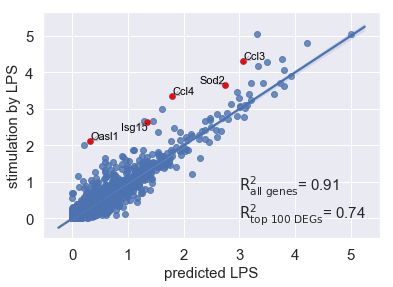

In [17]:
conditions = {"pred_stim": "pred_stim", "real_stim": "real_stim"}
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('xtick', labelsize=16)
scgen.plotting.reg_mean_plot(all_Data, 
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=gene_list[:5],
                             top_100_genes=gene_list,
                             path_to_save=os.path.join(path_to_save, f"Fig5b_study_reg_mean_all_genes.pdf"),
                             legend=False,
                             title="",
                             fontsize=15,
                             labels={"x":"predicted LPS", "y":"stimulation by LPS"},
                             show=True, 
                             x_coeff=0.40,
                             y_coeff=0.85,
                             range=[0, 7, 1])

### Figure 5.c

In [18]:
all_stim = sc.AnnData(np.concatenate([rat_stim.X.A, pred_rat1 ,rat_cd.X.A, rabbit_cd.X.A,
                                      rabbit_stim.X.A, pig_cd.X.A, pig_stim.X.A, mouse_cd.X.A,
                                      mouse_stim.X.A]))
all_stim.var_names = train.var_names
all_stim.obs["condition"] = ["rat_LPS6"] * len(rat_stim) + ["rat_LPS6_pred"] * len(pred_rat1) + ["rat_ctrl"]*len(rat_cd) + ["rabbit_ctrl"]*len(rabbit_cd)  + ["rabbit_LPS6"] *len(rabbit_stim)\
+ ["pig_ctrl"]*len(pig_cd) + ["pig_LPS6"]*len(pig_stim) + ["mouse_ctrl"]*len(mouse_cd)\
+ ["mouse_LPS6"]*len(mouse_stim)

... storing 'condition' as categorical


saving figure to file ../results/Figures/Figure 5/dotplot_cross_species.pdf


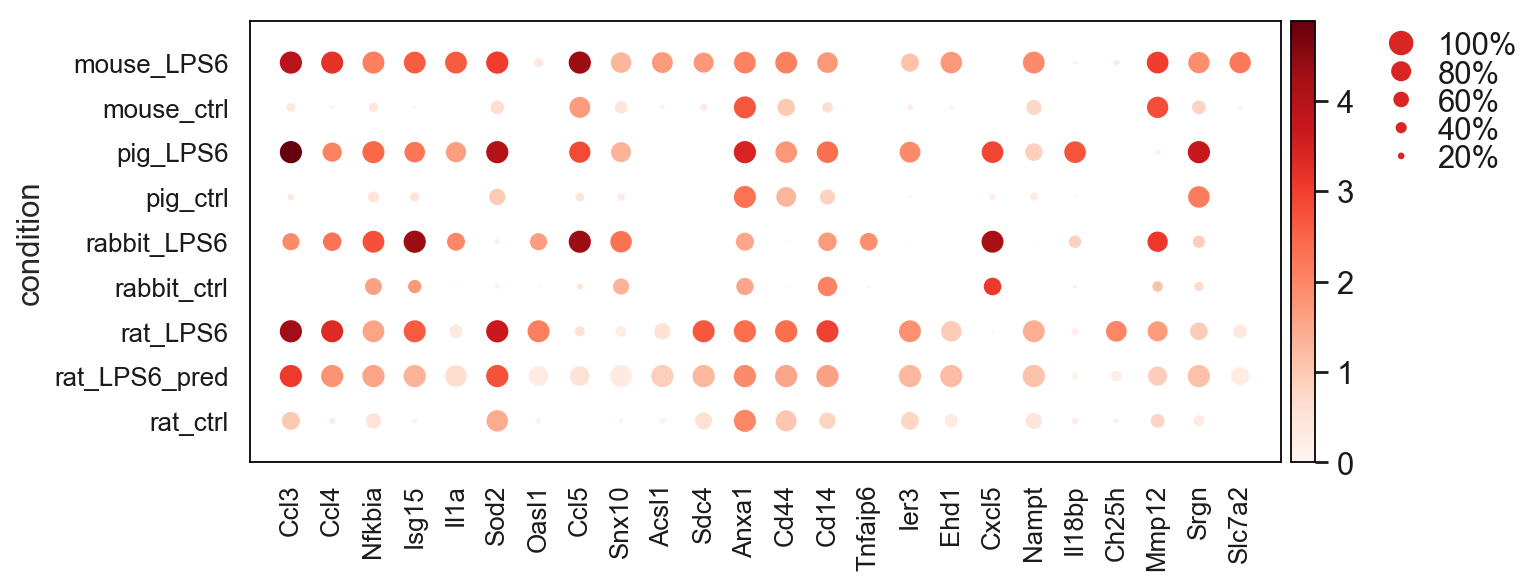

In [19]:
sc.set_figure_params(fontsize=14)
sc.pl.dotplot(all_stim, groupby="condition", var_names=gene_list_dot,
              save=f"_cross_species.pdf", use_raw=False)
os.rename(src=os.path.join(path_to_save, "dotplot_cross_species.pdf"), 
          dst=os.path.join(path_to_save, "Fig5c_dotplot_cross_species.pdf"))